In [1]:
import tensorflow as tf
from tensorflow.keras  import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch , label_batch in dataset.take(1):
    # print image shape
    print(image_batch.shape)
    # print label shape
    print(label_batch.shape)
    # print image tensor value
    print(image_batch[0].numpy())

(32, 256, 256, 3)
(32,)
[[[156. 158. 170.]
  [155. 157. 169.]
  [154. 156. 168.]
  ...
  [175. 178. 187.]
  [180. 183. 192.]
  [189. 192. 201.]]

 [[153. 155. 167.]
  [154. 156. 168.]
  [155. 157. 169.]
  ...
  [182. 185. 194.]
  [185. 188. 197.]
  [193. 196. 205.]]

 [[154. 156. 168.]
  [156. 158. 170.]
  [159. 161. 173.]
  ...
  [185. 188. 197.]
  [186. 189. 198.]
  [190. 193. 202.]]

 ...

 [[123. 120. 131.]
  [122. 119. 130.]
  [125. 122. 133.]
  ...
  [131. 130. 138.]
  [131. 130. 138.]
  [136. 135. 143.]]

 [[116. 113. 124.]
  [110. 107. 118.]
  [109. 106. 117.]
  ...
  [138. 137. 145.]
  [140. 139. 147.]
  [145. 144. 152.]]

 [[123. 120. 131.]
  [121. 118. 129.]
  [120. 117. 128.]
  ...
  [135. 134. 142.]
  [136. 135. 143.]
  [138. 137. 145.]]]


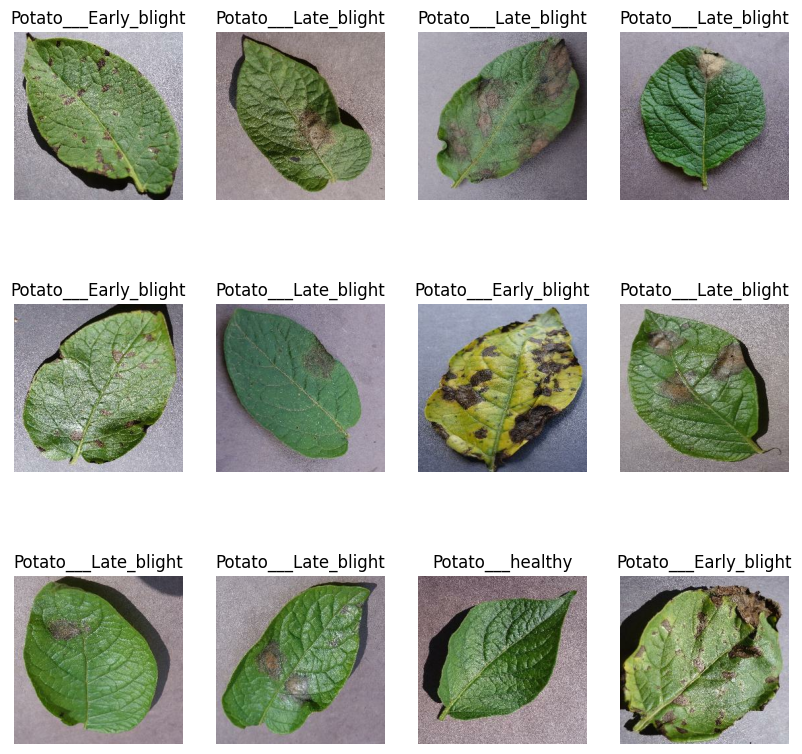

In [6]:
plt.figure(figsize=(10,10))
        
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
        plt.imshow(image_batch[i].numpy().astype("uint8"))

In [7]:
len(dataset)

68

In [8]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(test_ds)

8

In [18]:
len(val_ds)

6

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [21]:
data_augmentation =tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [25]:
histroy = model.fit(
    train_ds,
    epochs =EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
)

Epoch 1/50


c:\Users\utamp\anaconda3\envs\ai_exp\Lib\site-packages\keras\src\backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


54/54 [==============================] - 125s 2s/step - loss: 0.8520 - accuracy: 0.5260 - val_loss: 0.7774 - val_accuracy: 0.8073
Epoch 2/50
54/54 [==============================] - 99s 2s/step - loss: 0.6987 - accuracy: 0.6603 - val_loss: 0.5462 - val_accuracy: 0.7760
Epoch 3/50
54/54 [==============================] - 105s 2s/step - loss: 0.4998 - accuracy: 0.7656 - val_loss: 0.3771 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 114s 2s/step - loss: 0.3364 - accuracy: 0.8634 - val_loss: 0.1955 - val_accuracy: 0.9583
Epoch 5/50
54/54 [==============================] - 117s 2s/step - loss: 0.2334 - accuracy: 0.9051 - val_loss: 0.0966 - val_accuracy: 0.9844
Epoch 6/50
54/54 [==============================] - 121s 2s/step - loss: 0.1623 - accuracy: 0.9369 - val_loss: 0.0600 - val_accuracy: 0.9792
Epoch 7/50
54/54 [==============================] - 117s 2s/step - loss: 0.1631 - accuracy: 0.9363 - val_loss: 0.0812 - val_accuracy: 0.9740
Epoch 8/50
54/54 [=======

In [26]:
model_version = '2.0'
model.save(f'../models/{model_version}.h5')
model.save(f'../models/{model_version}')

c:\Users\utamp\anaconda3\envs\ai_exp\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: ../models/2.0\assets


INFO:tensorflow:Assets written to: ../models/2.0\assets


pip install split-folders
splitfolders --output dataset --ratio .7 .1 .2 -- PlantVillage
